# Analyser et Prédire le nombre de validation quotidienne sur le reseau ferre

### Table of contents
1. [L'analyse exploratoire des données](#AED)
2. [Analyse du nombre de validations:](#ANV)
3. [Analyse de nombre de validation en se basant sur les categories de titre:](#ANVCT)
4. [ANLYSER Les series temporelles pour les 2 arrêt OLYMPIADES ET MONTROUGE](#ASROM)
5. [Prédiction pour la station Olympiades entre 24 et 30 juin:](#ASRO)
6. [Evaluation](#EVO)
7. [Prédiction pour la station Montrouge entre 24 et 30 juin:](#ASRM)
8. [Evaluation](#EVM)
9. [Amélioration](#AM)

Avant de commencer on doit tout d'abord télécharger les données qu'on va l'utiliser pour analyser et préire

In [66]:
# télécharger les données
!wget --output-document="validation_sur_le_reseau_ferre.csv" "https://data.iledefrance-mobilites.fr/explore/dataset/validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-1er-sem/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B"

--2020-10-16 19:21:07--  https://data.iledefrance-mobilites.fr/explore/dataset/validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-1er-sem/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B
Resolving data.iledefrance-mobilites.fr (data.iledefrance-mobilites.fr)... 34.249.199.226, 34.248.20.69
Connecting to data.iledefrance-mobilites.fr (data.iledefrance-mobilites.fr)|34.249.199.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/csv]
Saving to: ‘validation_sur_le_reseau_ferre.csv’

validation_sur_le_r     [          <=>       ]  46,14M   139KB/s    in 9m 35s  

2020-10-16 19:30:45 (82,2 KB/s) - ‘validation_sur_le_reseau_ferre.csv’ saved [48380105]



In [340]:
# Importer les packages
import pandas as pd
from IPython.display import display, Markdown, Image
from datetime import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials # optimization
from sklearn.metrics import mean_squared_log_error
from math import sqrt
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings('ignore')

In [341]:
# lire les données
data = pd.read_csv('validation_sur_le_reseau_ferre.csv', sep = ';')

<a id='AED'></a>

# L'analyse exploratoire des données:

In [342]:
data.head()

,JOUR,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,LIBELLE_ARRET,ID_REFA_LDA,CATEGORIE_TITRE,NB_VALD
0,2020-01-25,800,822,2105,LES PAVILLONS-SOUS-BOIS,NaN,AMETHYSTE,11
1,2020-01-25,800,822,2107,LYCEE HENRI SELLIER,NaN,AMETHYSTE,Moins de 5
2,2020-01-25,800,822,2107,LYCEE HENRI SELLIER,NaN,IMAGINE R,44
3,2020-01-25,800,822,2107,LYCEE HENRI SELLIER,NaN,TST,Moins de 5
4,2020-01-25,800,822,2108,L'ABBAYE,NaN,AMETHYSTE,7


In [343]:
display(Markdown("Pourcentage de valeurs nulles pour chaque colonne : \n" ))
data.isnull().sum()/len(data)


Pourcentage de valeurs nulles pour chaque colonne : 


JOUR               0.000000
CODE_STIF_TRNS     0.000000
CODE_STIF_RES      0.000000
CODE_STIF_ARRET    0.000000
LIBELLE_ARRET      0.000000
ID_REFA_LDA        0.052504
CATEGORIE_TITRE    0.000000
NB_VALD            0.000000
dtype: float64

In [344]:
display(Markdown("On voit bien que le type NB_VALD est une chaine de caractères il vaut mieux de le convertir vers le type entier. Ainsi pour le JOUR, il vaut mieux de le convertir vers le type datetime python" ))

data.info()

On voit bien que le type NB_VALD est une chaine de caractères il vaut mieux de le convertir vers le type entier. Ainsi pour le JOUR, il vaut mieux de le convertir vers le type datetime python

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835141 entries, 0 to 835140
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   JOUR             835141 non-null  object 
 1   CODE_STIF_TRNS   835141 non-null  int64  
 2   CODE_STIF_RES    835141 non-null  object 
 3   CODE_STIF_ARRET  835141 non-null  object 
 4   LIBELLE_ARRET    835141 non-null  object 
 5   ID_REFA_LDA      791293 non-null  float64
 6   CATEGORIE_TITRE  835141 non-null  object 
 7   NB_VALD          835141 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 51.0+ MB


In [345]:
display(Markdown("Quelques informations sur la valeur 'Moins de 5' trouvé dans le document 'Présentation des données Open data': " +
"\n\n Par respect des exigences sur la protection des données personnelles, la mention « Moins de 5 » est indiquée pour les volumes inférieurs à 5 non nuls. La mention « 0 » est indiquée pour les volumes nuls."))

display(Markdown("Pourcentage de nombre de validation Moins de 5 est :  "+ 
                 str( round(len(data[data.NB_VALD =='Moins de 5'])/len(data),4)*100)+" %" + 
                 "\n\n On doit bien remplacer la category moins de 5, on va choisir 3 qui est le milieu de l'interval [1-5]  "
))


Quelques informations sur la valeur 'Moins de 5' trouvé dans le document 'Présentation des données Open data': 

 Par respect des exigences sur la protection des données personnelles, la mention « Moins de 5 » est indiquée pour les volumes inférieurs à 5 non nuls. La mention « 0 » est indiquée pour les volumes nuls.

Pourcentage de nombre de validation Moins de 5 est :  19.32 %

 On doit bien remplacer la category moins de 5, on va choisir 3 qui est le milieu de l'interval [1-5]  

In [346]:
# remplacer la valeur "moins de 5" et convertir le type de Nb_VALD en entier 
data.NB_VALD = data.NB_VALD.apply(lambda x: 3 if x=='Moins de 5' else int(x))

In [347]:
data.head()

,JOUR,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,LIBELLE_ARRET,ID_REFA_LDA,CATEGORIE_TITRE,NB_VALD
0,2020-01-25,800,822,2105,LES PAVILLONS-SOUS-BOIS,NaN,AMETHYSTE,11
1,2020-01-25,800,822,2107,LYCEE HENRI SELLIER,NaN,AMETHYSTE,3
2,2020-01-25,800,822,2107,LYCEE HENRI SELLIER,NaN,IMAGINE R,44
3,2020-01-25,800,822,2107,LYCEE HENRI SELLIER,NaN,TST,3
4,2020-01-25,800,822,2108,L'ABBAYE,NaN,AMETHYSTE,7


In [348]:
data.JOUR = data.JOUR.apply(lambda x:datetime.strptime(x, '%Y-%m-%d').date() )

In [349]:
data.JOUR.min() , data.JOUR.max()

(datetime.date(2020, 1, 1), datetime.date(2020, 6, 30))

le fichier contient les données de premier semestre de 01-01-2020 jusqu'à 30-06-2020


<a id='ANV'></a>

# Analyse du nombre de validations:

In [278]:
# Quelles sont les 20 premières stations en terme de nombre validations ?
top20_stations = data[['LIBELLE_ARRET','NB_VALD']].groupby('LIBELLE_ARRET').sum().sort_values('NB_VALD',ascending=False).reset_index().head(20)
top20_stations



,LIBELLE_ARRET,NB_VALD
0,SAINT-LAZARE,17775377
1,GARE DU NORD,7538501
2,MONTPARNASSE,6726059
3,GARE DE L'EST,5842491
4,LA DEFENSE-GRANDE ARCHE,5413369
5,GARE DE LYON,4077208
6,BIBLIOTHEQUE FRANCOIS MITTERRAND,3250739
7,LES HALLES,3033970
8,CHATELET-LES HALLES,2866968
9,BASTILLE,2433825


[]

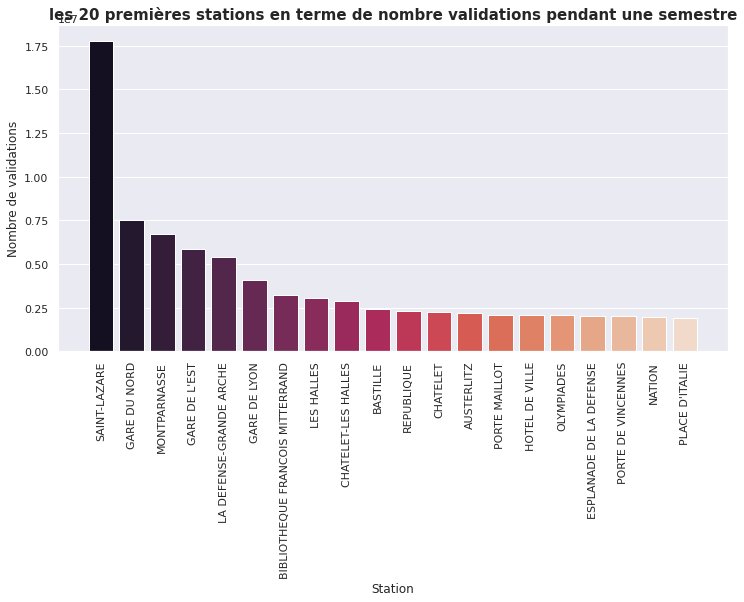

In [279]:
# une illustration graphique de ce classement.
f, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x="LIBELLE_ARRET",
            y="NB_VALD",
            data=top20_stations,
            palette=[sns.color_palette("rocket", 20)[i] for i in range(20)],
            ax=ax)

# set plot's labels

ax.set(xlabel='Station', ylabel='Nombre de validations')
ax.set_title("les 20 premières stations en terme de nombre validations pendant une semestre", fontweight="bold", size=15)
plt.xticks(rotation=90)
plt.plot()

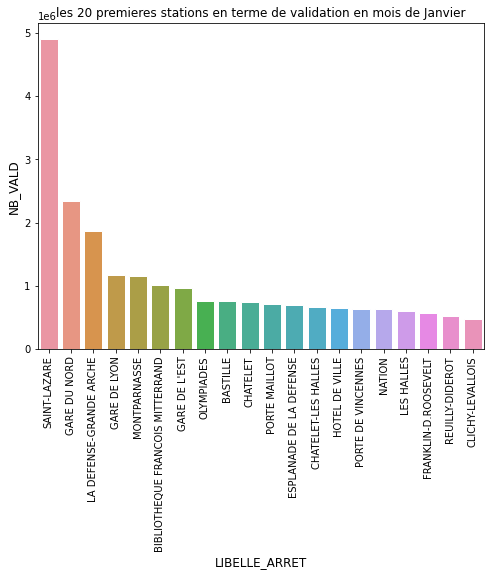

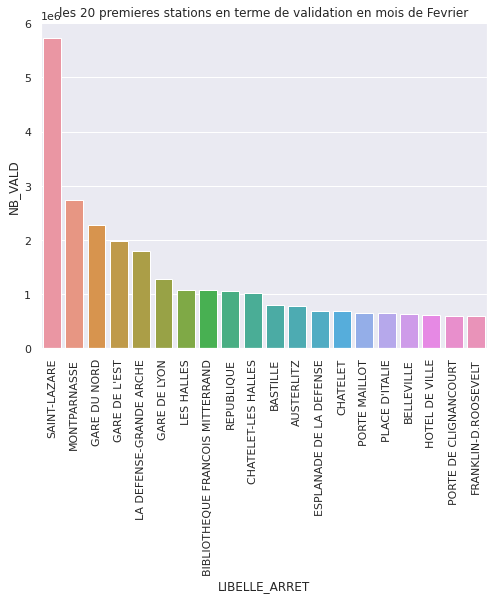

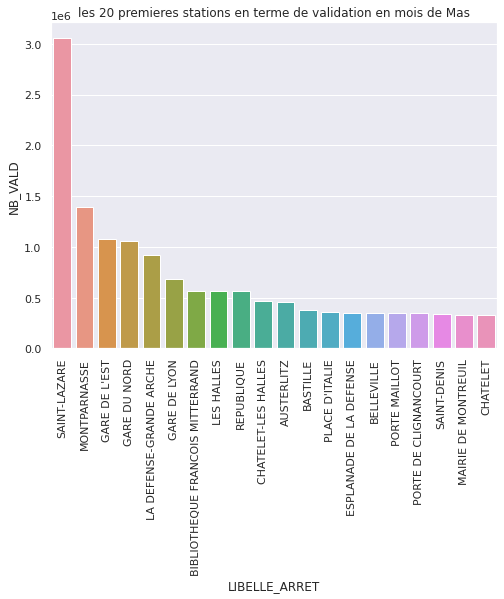

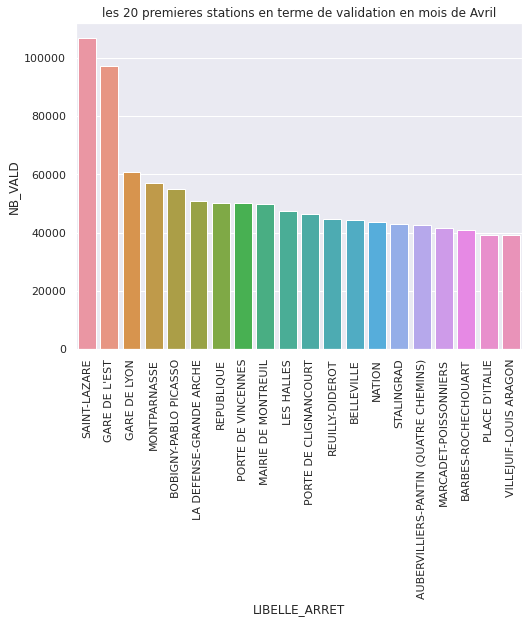

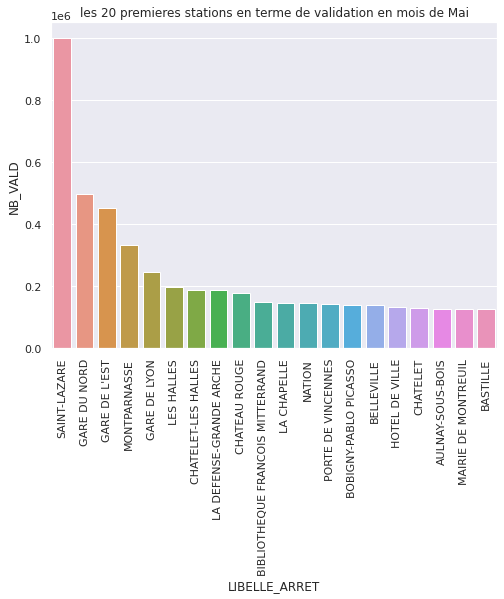

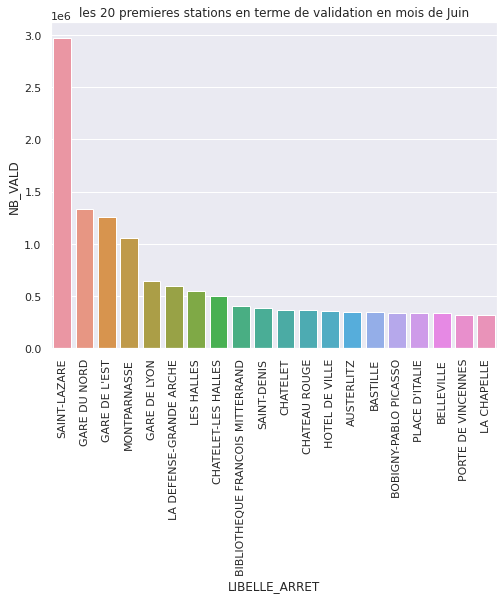

In [13]:
# une illustration graphique de classement par mois

data['month'] = [x.month  for x in data.JOUR]
nr_rows = 3
nr_cols = 2

id2mois = {1:'Janvier', 2:'Fevrier', 3:'Mas', 4:'Avril', 5:'Mai', 6:'Juin'}
for i in range(1,len(id2mois)+1):
    top20_par_mois = data.groupby(['month', 'LIBELLE_ARRET']).sum().NB_VALD[i].sort_values(ascending=False).head(20).to_frame().reset_index()
    x= top20_par_mois.LIBELLE_ARRET
    y= top20_par_mois.NB_VALD
    
    plt.figure(figsize=(8,6))
    plt.title('les 20 premieres stations en terme de validation en mois de '+id2mois[i])
    plt.ylabel('NB_VALD', fontsize=12)
    plt.xlabel('Station', fontsize=12)
    plt.xticks(rotation=90)
    sns.set(style="darkgrid")
    sns.barplot(x, y)



On voit bien que parmi les 20 premières stations en terme de nombre de validation sont les grandes gares en iles de france:\\
- la gare du Nord
- la gare de l'Est
- la gare Saint-Lazare
- la gare Montparnasse
- la gare d'Austerlitz
- la gare de Lyon 
<br>

On peut aussi expliquer le nombre élevé par le fait qu'il y a beaucoup de lignes disservi par ces stations. pour prouver ça je vais utilisé une autre data qui s'appelle "Gares et stations du réseau ferré d'Île-de-France (par ligne)" téléchargeable via ce lien https://data.iledefrance-mobilites.fr/explore/dataset/emplacement-des-gares-idf/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B


In [280]:
emplacement_des_gares_idf = pd.read_csv('emplacement-des-gares-idf.csv',sep=';')
emplacement_des_gares_idf.nom_gare = emplacement_des_gares_idf.nom_gare.apply(lambda x:x.lower())

In [281]:
emplacement_des_gares_idf.head()

,Geo Point,Geo Shape,OBJECTID,id_ref_zdl,gares_id,nom_gare,nomlong,nom_iv,num_mod,mode_,...,res_com,cod_resf,res_stif,exploitant,num_psr,idf,principal,x,y,picto ligne
0,"48.8794817719,2.38911580738","{""type"": ""Point"", ""coordinates"": [2.3891158073...",3,42369,93,botzaris,BOTZARIS,Botzaris,2362,Metro,...,M7bis,3.0,110.0,RATP,0,1,0,655197.2716,6.864558e+06,https://data.iledefrance-mobilites.fr/api/v2/c...
1,"48.8607869635,2.32099819195","{""type"": ""Point"", ""coordinates"": [2.3209981919...",27,45704,30,assemblée nationale,ASSEMBLEE NATIONALE,Assemblée Nationale,2312,Metro,...,M12,3.0,110.0,RATP,0,1,0,650183.7135,6.862520e+06,https://data.iledefrance-mobilites.fr/api/v2/c...
2,"48.8359308792,2.27816167128","{""type"": ""Point"", ""coordinates"": [2.2781616712...",31,45357,47,balard,BALARD,Balard,2225,Metro,...,M8,3.0,110.0,RATP,0,1,0,647015.7484,6.859784e+06,https://data.iledefrance-mobilites.fr/api/v2/c...
3,"48.8524794228,2.36932058493","{""type"": ""Point"", ""coordinates"": [2.3693205849...",34,42288,54,bastille,BASTILLE,Bastille,2017,Metro,...,M1,3.0,110.0,RATP,0,1,0,653721.5234,6.861567e+06,https://data.iledefrance-mobilites.fr/api/v2/c...
4,"48.8413382509,2.40091853812","{""type"": ""Point"", ""coordinates"": [2.4009185381...",37,45222,59,bel air,BEL-AIR,Bel-Air,2125,Metro,...,M6,3.0,110.0,RATP,0,1,0,656030.6977,6.860310e+06,https://data.iledefrance-mobilites.fr/api/v2/c...


In [286]:
emplacement_des_gares_idf = emplacement_des_gares_idf[['nomlong', 'train','rer', 'metro']]
station_nb_ligne = pd.DataFrame(emplacement_des_gares_idf.groupby('nomlong').sum().sum(axis=1).sort_values(ascending=False)).reset_index().rename(columns = {0:'nb_lignes'}).head(20)
station_nb_ligne

,nomlong,nb_lignes
0,GARE DU NORD,6
1,SAINT-LAZARE,6
2,GARE DE LYON,5
3,MONTPARNASSE,5
4,CHATELET,5
5,NATION,5
6,REPUBLIQUE,5
7,GARE DE L'EST,4
8,LA DEFENSE-GRANDE ARCHE,4
9,CHARLES DE GAULLE ETOILE,4


In [287]:
emplacement_des_gares_idf = emplacement_des_gares_idf.merge(station_nb_ligne,on = 'nomlong',how = 'left')
emplacement_des_gares_idf.nomlong = emplacement_des_gares_idf.nomlong.apply(lambda x:x.lower())
top20_stations.LIBELLE_ARRET = top20_stations.LIBELLE_ARRET.apply(lambda x : x.lower())
NB_VALD_nb_lignes = top20_stations.merge(emplacement_des_gares_idf[['nomlong','nb_lignes']].drop_duplicates(),left_on='LIBELLE_ARRET', right_on='nomlong', how='left').drop('nomlong',axis=1)
NB_VALD_nb_lignes

,LIBELLE_ARRET,NB_VALD,nb_lignes
0,saint-lazare,17775377,6.0
1,gare du nord,7538501,6.0
2,montparnasse,6726059,5.0
3,gare de l'est,5842491,4.0
4,la defense-grande arche,5413369,4.0
5,gare de lyon,4077208,5.0
6,bibliotheque francois mitterrand,3250739,NaN
7,les halles,3033970,NaN
8,chatelet-les halles,2866968,NaN
9,bastille,2433825,NaN


ps. Pour les valeurs nulles, peut être à cause de nom de l'arret qui diffère entre le deux tableaux.

In [350]:
# à partir de l'internet j'ai ajouté le nombre de ligne pour chaque station ou la valeur est nulle
NB_VALD_nb_lignes['nb_lignes'].iloc[6] = 2
NB_VALD_nb_lignes['nb_lignes'].iloc[7] = 1
NB_VALD_nb_lignes['nb_lignes'].iloc[8] = 3
NB_VALD_nb_lignes['nb_lignes'].iloc[9] = 3
NB_VALD_nb_lignes['nb_lignes'].iloc[13] = 2
NB_VALD_nb_lignes['nb_lignes'].iloc[14] = 2
NB_VALD_nb_lignes['nb_lignes'].iloc[15] = 1
NB_VALD_nb_lignes['nb_lignes'].iloc[16] = 1
NB_VALD_nb_lignes['nb_lignes'].iloc[17] = 3
NB_VALD_nb_lignes['nb_lignes'].iloc[19] = 3


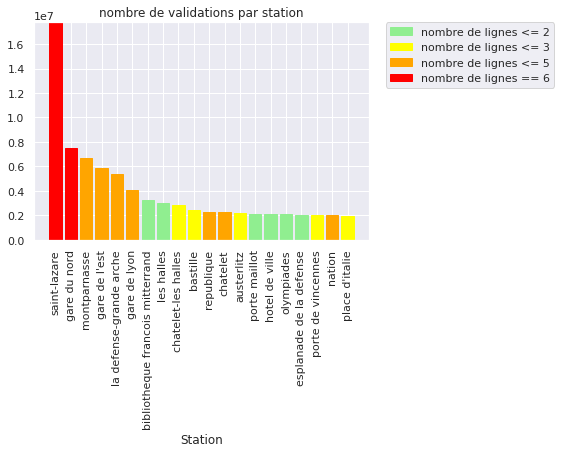

In [289]:
import matplotlib.patches as mpatches
plt.xlabel("Station")
plt.ylabel("")
plt.title('nombre de validations par station')
plt.grid(True,which="both",ls="-")
bars = plt.bar(NB_VALD_nb_lignes['LIBELLE_ARRET'], NB_VALD_nb_lignes['NB_VALD'], align='center', edgecolor = "black")
for i in range(0, len(bars)):
    if NB_VALD_nb_lignes['nb_lignes'][i] <= 2:
        color = 'lightgreen'
    elif NB_VALD_nb_lignes['nb_lignes'][i] <=3:
        color = 'yellow'
    elif NB_VALD_nb_lignes['nb_lignes'][i] <=5:
        color = 'orange'
    elif NB_VALD_nb_lignes['nb_lignes'][i]== 6:
        color = 'red'

    bars[i].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='nombre de lignes <= 2')
patch2 = mpatches.Patch(color='yellow', label='nombre de lignes <= 3')
patch3 = mpatches.Patch(color='orange', label='nombre de lignes <= 5')
patch4 = mpatches.Patch(color='red', label='nombre de lignes == 6')

plt.xticks(rotation=90)

plt.legend(handles=[patch1, patch2, patch3, patch4], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.margins(0.05, 0)
plt.show()

- Pour le 6 premières stations on voit bien qu'il y a une correlation entre le nombre de ligne disservi et le nombre de validation mais pour les autres on perd cette correlation donc normalement il y a d'autres facteurs qui affectent le nombre de validations comme la localisation de station  <br>



<a id='ANVCT'></a>

# Analyse de nombre de validation en se basant sur les categories de titre:

Avant de commencer j'ai définit les differents titre qu'on peut trouver dans les données:

- « IMAGINE R » : regroupe les forfaits annuels Imagine R Scolaire et Imagine R Etudiant, forfaits
réservés aux élèves, apprentis et étudiants qui permet de voyager à volonté toute l’année et dans
toute l'Ile-de-France.<br>
- « NAVIGO » : regroupe les forfaits Navigo Annuel, Navigo Mois et Navigo Semaine.<br>
- « AMETHYSTE » : comptabilise les forfaits Améthyste : forfait réservé aux personnes âgées ou
handicapées sous conditions de ressources ou de statut, et résidant en Île-de-France. Ce forfait
annuel permet à son bénéficiaire de se déplacer de manière illimitée sur tous les modes de
transport à l'intérieur des zones de validité.<br>
- « TST » : regroupe les forfaits hebdomadaires et mensuels à tarif réduit, accordé aux bénéficiaires
de la Réduction Solidarité Transport, pour voyager à l’intérieur des zones choisies sur tous les
modes de transport en Île-de-France.<br>
- « FGT » : comptabilise les Forfaits Navigo Gratuité Transport, forfait qui permet à certain
bénéficiaire d’aides sociales de voyager gratuitement dans toute l’Île-de-France.<br>
- « AUTRE TITRE » : comptabilise les forfaits spéciaux.<br>
- « NON DEFINI » : comptabilise les validations dont le type de titre n’est pas défini (anomalies).

In [293]:
data.LIBELLE_ARRET = data.LIBELLE_ARRET.apply(lambda x:x.lower())
NB_VALD_CATEG = data.groupby(['LIBELLE_ARRET' ,'CATEGORIE_TITRE']).sum().NB_VALD
CATEG_TITRE_LS = data.CATEGORIE_TITRE.unique().tolist()
top20_stations_name = top20_stations.LIBELLE_ARRET.to_list()
frequencies = [[NB_VALD_CATEG[station][cat] for cat in CATEG_TITRE_LS] for station in top20_stations_name]

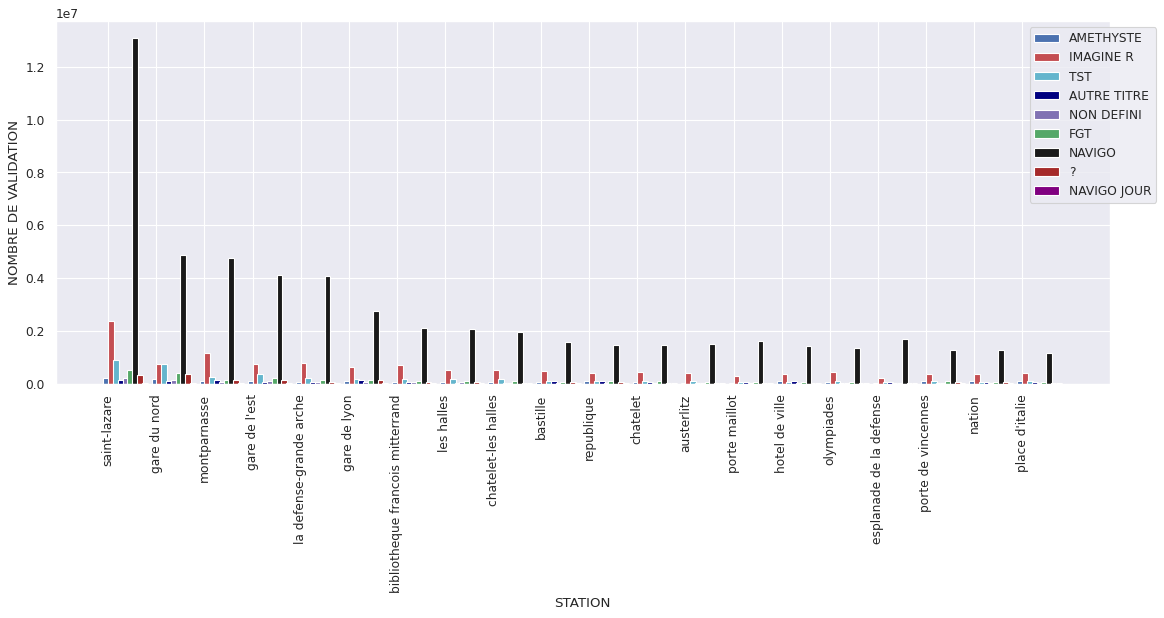

<Figure size 1440x1080 with 0 Axes>

In [294]:

plt.figure(num=None, figsize=(17, 6), dpi=80, facecolor='w', edgecolor='k')
# data to plot
n_groups = 20
colors = ['b',  'r', 'c',  'navy', 'm','g','k','brown','purple']
# create plot
index = np.arange(0, n_groups * 5, 5)
bar_width = 0.5
opacity = 1

for i in range(len(CATEG_TITRE_LS)):
    plt.bar(index+bar_width*i,tuple([row[i] for row in frequencies]),align='edge',width=0.6,
    alpha=opacity,
    color=colors[i],
    label=CATEG_TITRE_LS[i])

plt.xlabel('STATION')
plt.ylabel('NOMBRE DE VALIDATION')
plt.xticks(index + bar_width, ('saint-lazare',
 'gare du nord',
 'montparnasse',
 "gare de l'est",
 'la defense-grande arche',
 'gare de lyon',
 'bibliotheque francois mitterrand',
 'les halles',
 'chatelet-les halles',
 'bastille',
 'republique',
 'chatelet',
 'austerlitz',
 'porte maillot',
 'hotel de ville',
                               
 'olympiades',
 'esplanade de la defense',
 'porte de vincennes',
 'nation',
 "place d'italie"),rotation='vertical')
plt.legend();
plt.legend(bbox_to_anchor=(1.05, 1));

plt.figure(figsize=(20,15));
plt.show();

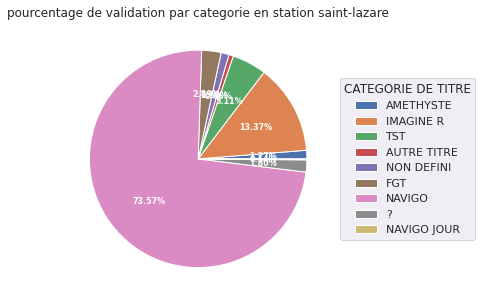

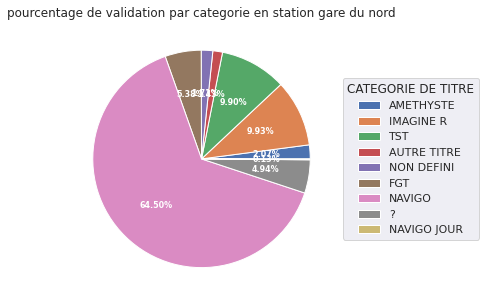

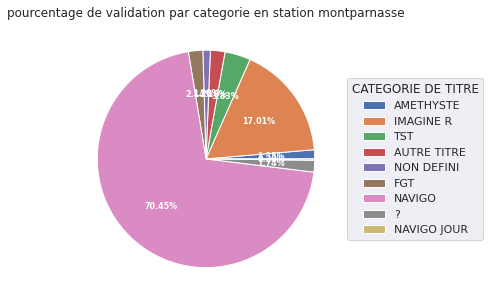

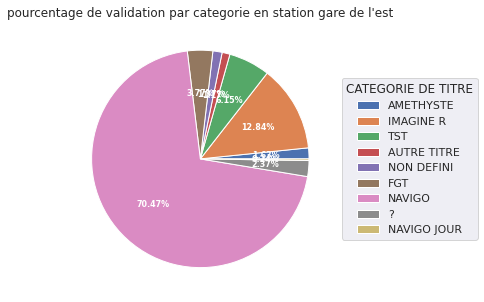

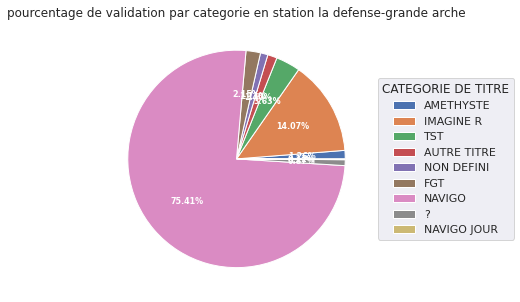

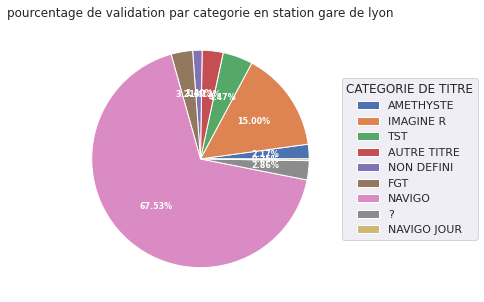

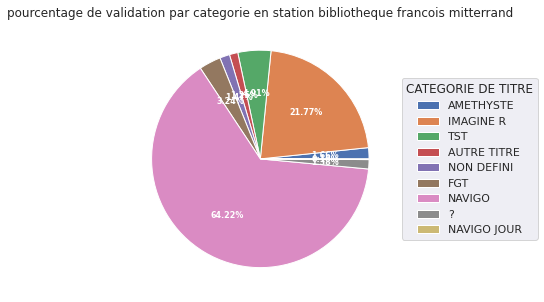

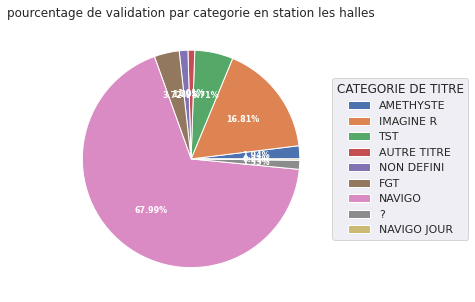

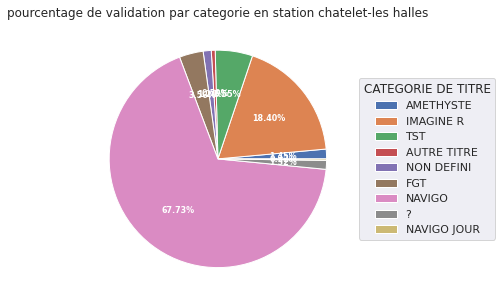

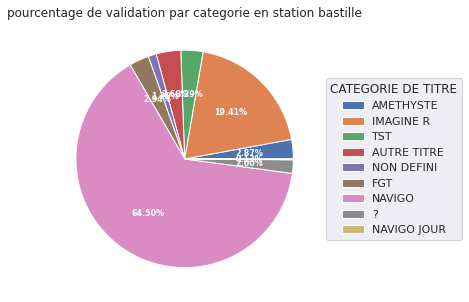

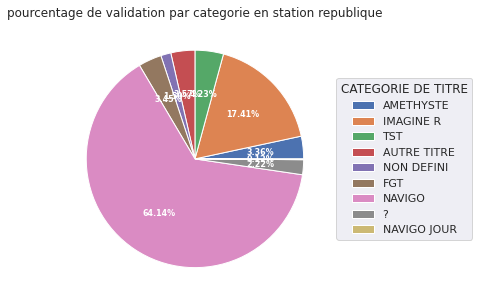

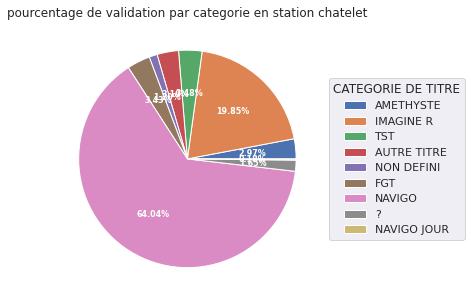

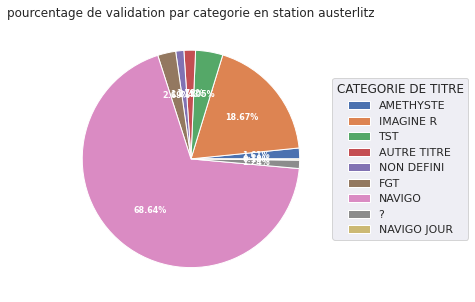

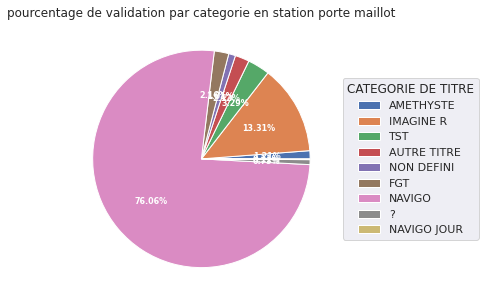

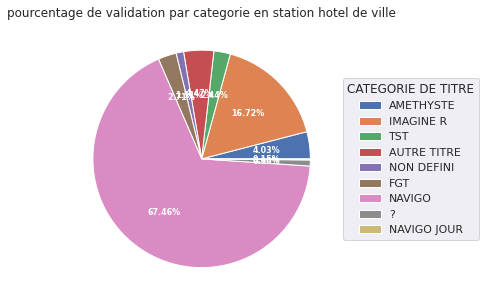

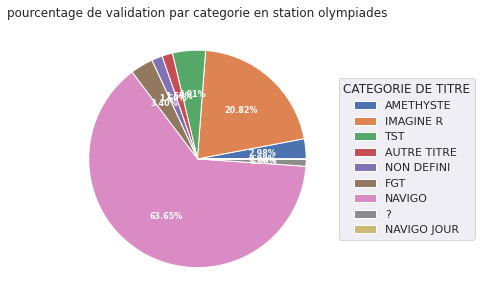

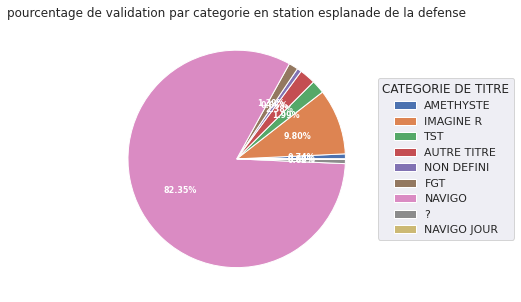

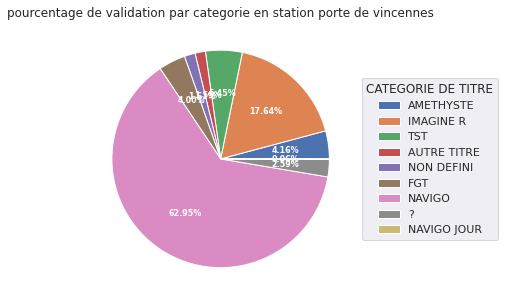

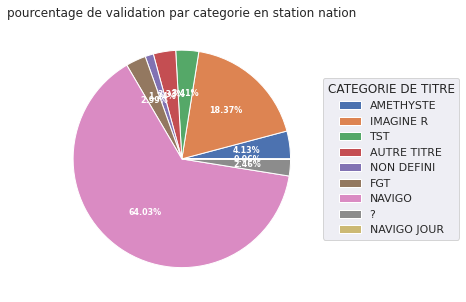

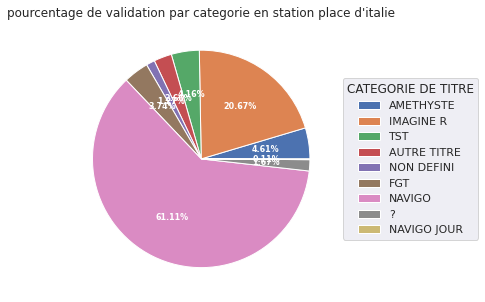

In [295]:
import numpy as np
import matplotlib.pyplot as plt
for i in range(20):
    fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(aspect="equal"))

    nb_val = frequencies[i]
    ingredients = CATEG_TITRE_LS




    wedges, texts, autotexts = ax.pie(nb_val, autopct='%.2f%%',
                                      textprops=dict(color="w"))
    ax.legend(wedges, ingredients,
              title="CATEGORIE DE TITRE",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=8, weight="bold")

    ax.set_title("pourcentage de validation par categorie en station {}".format(top20_stations_name[i]))

    plt.show()

les figures présentent les pourcentages de nombre de validation par categories pour chaque station. On voit bien que la plupart de validations vient du pass NAVIGO et une partie non negligeable à partir de IMAGINE R. 


# Prédicitons:

<a id='ASROM'></a>

### ANLYSER Les series temporelles pour les 2 arrêt OLYMPIADES ET MONTROUGE

In [296]:
olympiades = data[data.LIBELLE_ARRET=='olympiades']
montrouge = data[data.LIBELLE_ARRET=='m. montrouge']

In [297]:
TS_OLYMP = olympiades[['JOUR','NB_VALD']].groupby('JOUR').sum()
TS_OLYMP = TS_OLYMP.reset_index()
TS_MONT = montrouge[['JOUR','NB_VALD']].groupby('JOUR').sum()
TS_MONT = TS_MONT.reset_index()


In [298]:

fig = px.line(TS_OLYMP, x="JOUR", y="NB_VALD", title='Nombre de validation par jour en station olympiade')

fig.show()

In [299]:
fig = px.line(TS_MONT, x="JOUR", y="NB_VALD", title='Nombre de validation par jour en station montrouge')
fig.show()

- D'après le 2 figures, nous pouvons voir que entre 17 mars 2020 et 11 mai 2020 qui est le debut et la fin de confinement en france, il y a une baisse trés importante pour le nombre de validation par jour. Donc on va ajouter une information binaire qui s'appelle EST_CONFINEMENT pour indiquer au modèle que le jour j est un confinement ou non. <br>
- D'apres le 2 figure, chaque dimanche il y a une baisse importante de nombre de validation. <br>
- On peut dire aussi que notre series temporelle a une periodicité qui est une semaine. <br>
- Rechercher une base de données des jours fériés (fériés ou non et si oui, le type de ce jour: Week-end, Noël, Toussaint, ...), Base de données exploitée: https://www.data.gouv.fr/fr/datasets/jours-feries-en-france/ 


In [163]:
# télécharger les données pour les jours féries
!wget --output-document="jours_feries_metropole.csv" "https://etalab.github.io/jours-feries-france-data/csv/jours_feries_metropole.csv"

--2020-10-16 22:49:50--  https://etalab.github.io/jours-feries-france-data/csv/jours_feries_metropole.csv
Resolving etalab.github.io (etalab.github.io)... 185.199.110.153, 185.199.111.153, 185.199.108.153, ...
Connecting to etalab.github.io (etalab.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11159 (11K) [text/csv]
Saving to: ‘jours_feries_metropole.csv’

jours_feries_metrop 100%[===================>]  10,90K  --.-KB/s    in 0,006s  

2020-10-16 22:49:51 (1,93 MB/s) - ‘jours_feries_metropole.csv’ saved [11159/11159]



In [164]:
JOURS_FERIES = pd.read_csv('jours_feries_metropole.csv')
JOURS_FERIES.date = JOURS_FERIES.date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d').date() )# convertir en datetime python

In [165]:
# Fonction utiles
def Creer_date_features(df,label=None):
    '''
    extracter des informations à partir de la date et l'ajouter à notre dataframe
    retourne dataframe qui contient tous les features qu'on va l'exploiter pour entrainer notre modèle de regression
    '''
    df['month'] = df['JOUR'].apply(lambda x: x.month)
    df['dayofmonth'] = df['JOUR'].apply(lambda x: x.day)
    df['week'] = df['JOUR'].apply(lambda x: x.isocalendar()[1])
    df['dayofweek'] = df['JOUR'].apply(lambda x: x.weekday())

    
    X = df[['JOUR','month','week','dayofmonth','dayofweek','1er janvier','EST_CONFINEMENT','1er mai','8 mai','Ascension' ,'Lundi de Pentecôte' ,'Lundi de Pâques' ,'NON_FERIE']]
    if label:
        y = df[label]
        return X, y
    return X

def creer_donnee(TS, JOURS_FERIES, label=None):
    '''
    cette fonction retourne les données qu'on va l'utiliser pour l'entrainemen, pour validation et pour le test
    '''
    TS_FE = JOURS_FERIES.merge(TS, left_on='date',right_on='JOUR',how='right')[['JOUR','NB_VALD','nom_jour_ferie']]
    TS_FE.nom_jour_ferie = TS_FE.nom_jour_ferie.fillna('NON_FERIE')
    
    TS_FE = JOURS_FERIES.merge(TS, left_on='date',right_on='JOUR',how='right')[['JOUR','NB_VALD','nom_jour_ferie']]
    TS_FE.nom_jour_ferie = TS_FE.nom_jour_ferie.fillna('NON_FERIE')
    # Ajouter les dates de confinment comme colonne
    TS_FE['EST_CONFINEMENT'] = [1 if ((x>= datetime.strptime("2020-03-17", '%Y-%m-%d').date()) & (x<=datetime.strptime("2020-05-11", '%Y-%m-%d').date())) else 0 for x in TS_FE.JOUR]
    TS_FE = pd.concat([TS_FE, pd.get_dummies(TS_FE.nom_jour_ferie)], axis=1, join='inner').drop('nom_jour_ferie',axis=1)
 
    TRAIN = TS_FE[TS_FE.JOUR<datetime.strptime("2020-06-18", '%Y-%m-%d').date()]
    # pour la validation j'ai pris la même nombre de jours que le test
    VAL = TS_FE[((TS_FE.JOUR>=datetime.strptime("2020-06-18", '%Y-%m-%d').date())&(TS_FE.JOUR<datetime.strptime("2020-06-24", '%Y-%m-%d').date()))]
    TEST = TS_FE[TS_FE.JOUR>=datetime.strptime("2020-06-24", '%Y-%m-%d').date()] # la periode de 24 à 30 juin
    
    X_train, y_train = Creer_date_features(TRAIN, label='NB_VALD')
    X_test, y_test = Creer_date_features(TEST, label='NB_VALD')
    X_val, y_val = Creer_date_features(VAL, label='NB_VALD')
    
    return X_train,y_train,X_test,y_test,X_val,y_val


<a id='ASRO'></a>

## Prédiction pour la station Olympiades entre 24 et 30 juin:

In [300]:
# Ajouter les jours feries comme colonne
TS_OLYMP_FE = JOURS_FERIES.merge(TS_OLYMP, left_on='date',right_on='JOUR',how='right')[['JOUR','NB_VALD','nom_jour_ferie']]
# remplir les valeurs nulle par la catégorie "NON_FERIE" 
TS_OLYMP_FE.nom_jour_ferie = TS_OLYMP_FE.nom_jour_ferie.fillna('NON_FERIE') 

On divise les données en 3 parties : 
   - train: pour entrainer le modèle
   - val: pour valider le modèle à chaque iteration
   - test: pour tester le modèle finale

In [351]:
X_train,y_train,X_test,y_test,X_val,y_val = creer_donnee(TS_OLYMP,JOURS_FERIES,'NB_VALD')

## Entrainement de XGBOOST Regressor et son optimization

In [323]:
# on définit l'espace de recherche pour l'optimization bayesienne  
space={'max_depth': hp.uniform("max_depth", 1, 100),
        'gamma': hp.uniform ('gamma', 0,9),
        'reg_alpha' : hp.uniform('reg_alpha', 0,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,2),
       'learning_rate':hp.uniform('learning_rate',0,2),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0,1),
        'min_child_weight' : hp.uniform('min_child_weight', 0, 3),
        'n_estimators': hp.uniform('n_estimators', 200,3000)
    }

def hyperparameter_tuning(space):
    rmses = []
    # definit xgboostregressor
    reg=xgb.XGBRegressor(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                         reg_alpha = space['reg_alpha'],min_child_weight=space['min_child_weight'],
                         colsample_bytree=space['colsample_bytree'],random_state=20)
    
    # utilisé pour valider le modèle
    evaluation = [( X_val.drop('JOUR',axis=1), y_val)]
    
    # commencer l'entrainement
    reg.fit(X_train.drop('JOUR',axis=1), y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=500,verbose=False)

    pred = reg.predict(X_test.drop('JOUR',axis=1))
    rmse = sqrt(mean_squared_log_error(y_test, pred))  
    rmses.append(rmse)
    #change the metric if you like
    return {'loss':rmse, 'status': STATUS_OK }

In [324]:
trials_ = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=1000,
            trials=trials_)
print (best)

100%|██████████| 1000/1000 [04:55<00:00,  3.39trial/s, best loss: 0.15155279147066897]
{'colsample_bytree': 0.9477244430587637, 'gamma': 1.7660960256177913, 'learning_rate': 1.2246049383959505, 'max_depth': 9.099301330231002, 'min_child_weight': 2.907719333641754, 'n_estimators': 2725.7024086503916, 'reg_alpha': 0.13182077179401064, 'reg_lambda': 1.308422011369086}


In [325]:
# entrainement du modele XGBOOST REGRESSOR
reg=xgb.XGBRegressor(n_estimators =int(best['n_estimators']), max_depth = int(best['max_depth']), gamma = best['gamma'],
                     reg_alpha = best['reg_alpha'],min_child_weight=best['min_child_weight'],
                     colsample_bytree=best['colsample_bytree'],random_state=1)
# reg=xgb.XGBRegressor()
evaluation = [( X_val.drop('JOUR',axis=1), y_val)]

reg.fit(X_train.drop('JOUR',axis=1), y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=100,verbose=False)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9477244430587637,
             gamma=1.7660960256177913, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.300000012,
             max_delta_step=0, max_depth=9, min_child_weight=2.907719333641754,
             missing=nan, monotone_constraints=None, n_estimators=2725,
             n_jobs=0, num_parallel_tree=1, random_state=1,
             reg_alpha=0.13182077179401064, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method=None, validate_parameters=False,
             verbosity=None)

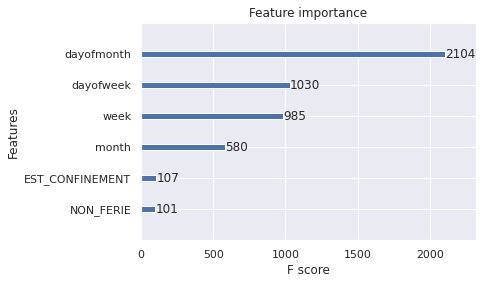

In [326]:
_ = plot_importance(reg)

À partir de figure on peut voir l'importance de features utilisé par le Xgboost pour la prédiction. On voit bien que notre modèle a utilisé les 2 features EST_Confinement et NON_FERIE pour faire la decision.

<a id='EVO'></a>

# Evaluation:

Pour l'evaluation du modèle j'ai utilisé root mean squared logarithm error (rmsle) 

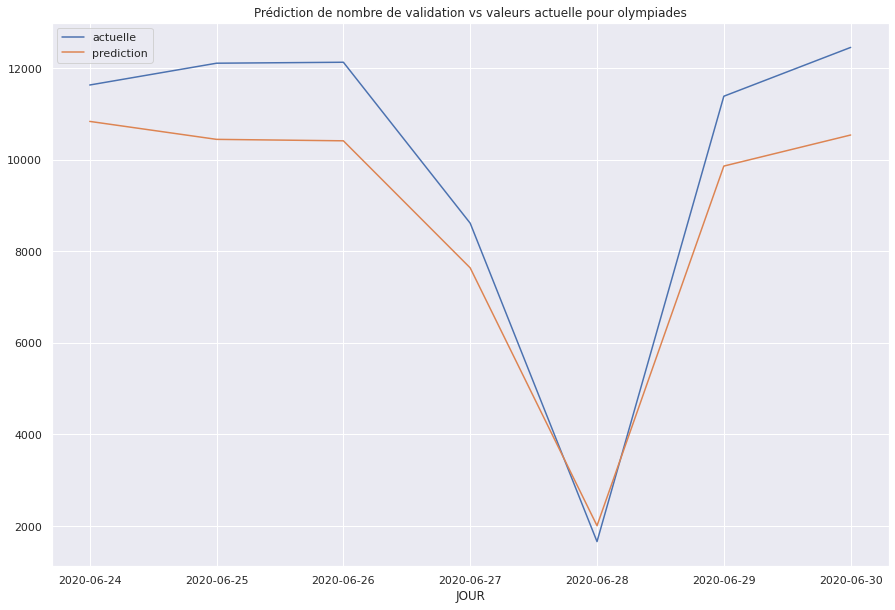

In [327]:
test_pred = reg.predict(X_test.drop('JOUR',axis=1))
X_Test = X_test
X_Test['actuelle'] = y_test
X_Test['prediction'] = test_pred
X_Test[['actuelle','prediction','JOUR']].set_index('JOUR').plot(figsize=(15,10),title='Prédiction de nombre de validation vs valeurs actuelle pour olympiades')

In [312]:
X_test=X_test.drop(['actuelle','prediction'],axis=1)

In [329]:
# 
rmse = sqrt(mean_squared_log_error(y_test, test_pred))    
print ("Root Mean Squared Logarith Error:", rmse)

Root Mean Squared Logarith Error: 0.14592800396536823


<a id='ASRM'></a>

## Prédiction pour la station Montrouge entre 24 et 30 juin:

In [352]:
TS_MONT_FE = JOURS_FERIES.merge(TS_MONT, left_on='date',right_on='JOUR',how='right')[['JOUR','NB_VALD','nom_jour_ferie']]
TS_MONT_FE.nom_jour_ferie = TS_MONT_FE.nom_jour_ferie.fillna('NON_FERIE')
X_train,y_train,X_test,y_test,X_val,y_val = creer_donnee(TS_MONT,JOURS_FERIES,'NB_VALD')

In [331]:
space={'max_depth': hp.uniform("max_depth", 1, 100),
        'gamma': hp.uniform ('gamma', 0,9),
        'reg_alpha' : hp.uniform('reg_alpha', 0,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,2),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0,1),
        'min_child_weight' : hp.uniform('min_child_weight', 0, 3),
        'n_estimators': hp.uniform('n_estimators', 200,3000)
    }
# Regression: 
def hyperparameter_tuning(space):
    rmses=[]
    reg=xgb.XGBRegressor(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                         reg_alpha = space['reg_alpha'],min_child_weight=space['min_child_weight'],
                         colsample_bytree=space['colsample_bytree'],random_state=20)
    
    evaluation = [( X_val.drop('JOUR',axis=1), y_val)]
    
    reg.fit(X_train.drop('JOUR',axis=1), y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=100,verbose=False)

    pred = reg.predict(X_test.drop('JOUR',axis=1))
    rmse = sqrt(mean_squared_log_error(y_test, pred))   
    #change the metric if you like
    return {'loss':rmse, 'status': STATUS_OK }

trials_ = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=1000,
            trials=trials_)


100%|██████████| 1000/1000 [01:12<00:00, 13.87trial/s, best loss: 0.20662281759617965]


In [332]:
# entrainement du modele XGBOOST REGRESSOR
reg=xgb.XGBRegressor(n_estimators =int(best['n_estimators']), max_depth = int(best['max_depth']), gamma = best['gamma'],
                     reg_alpha = best['reg_alpha'],min_child_weight=best['min_child_weight'],
                     colsample_bytree=best['colsample_bytree'],random_state=1)

evaluation = [( X_val.drop('JOUR',axis=1), y_val)]

reg.fit(X_train.drop('JOUR',axis=1), y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=100,verbose=False)


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.061863722979262084,
             gamma=2.8366135355335302, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.300000012,
             max_delta_step=0, max_depth=4, min_child_weight=1.9841131425980303,
             missing=nan, monotone_constraints=None, n_estimators=2996,
             n_jobs=0, num_parallel_tree=1, random_state=1,
             reg_alpha=0.02168442901791131, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method=None, validate_parameters=False,
             verbosity=None)

<a id='EVM'></a>

# Evaluation:

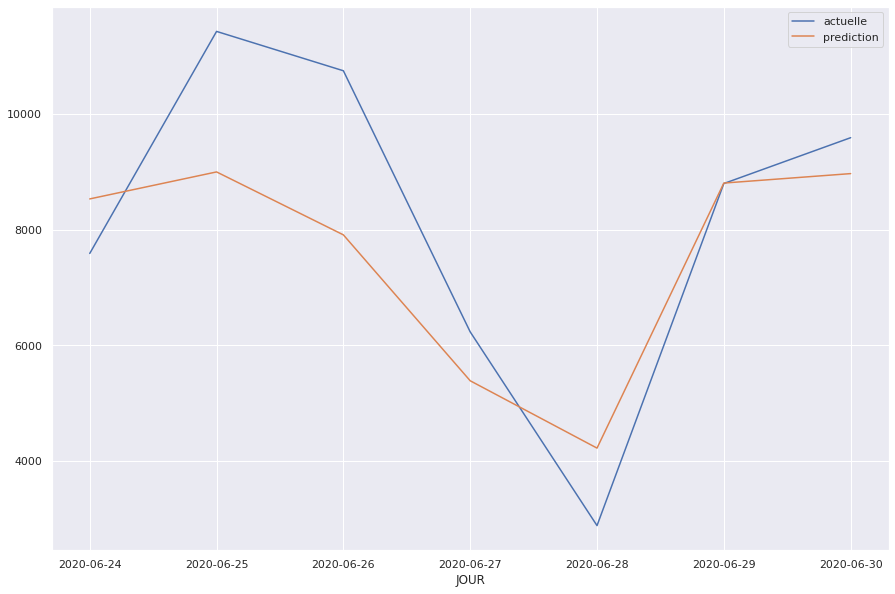

In [333]:
test_pred = reg.predict(X_test.drop('JOUR',axis=1))
X_Test = X_test
X_Test['actuelle'] = y_test
X_Test['prediction'] = test_pred
X_Test[['actuelle','prediction','JOUR']].set_index('JOUR').plot(figsize=(15,10))

In [334]:
# evaluation
rmse = sqrt(mean_squared_log_error(y_test, test_pred))    
print ("SCORE:", rmse)

SCORE: 0.21941650287479697


<a id='AM'></a>

# Améliorations:

$$rmse =  log_{10}(y -_true) - log_{10}(y - _pred)) $$

- Tester d'autres modèles de regression avec optimization
- Combiner les différents modèle en un seule modèle
- Trouver d'autres informations qui aide à prédire correctement le nombre de validation ( s'il ya de grève ou non, s'il y a des travaux ou non, ...)
